In [1]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from island import Island
from geometry import *
from continuum import Continuum

# Continuum with an island chain

## 1. Previous works

### 1.1 Three papers by Alessandro Biancalani with Chen and Zonca.

1. A. Biancalani, L. Chen, F. Pegoraro, and F. Zonca, Continuous Spectrum of Shear Alfvén Waves within Magnetic Islands, Phys. Rev. Lett. 105, 095002 (2010).
2. A. Biancalani, L. Chen, F. Pegoraro, and F. Zonca, Shear Alfvén Wave Continuous Spectrum within Magnetic Islands, Phys. Plasmas 17, 122106 (2010).
3. A. Biancalani, L. Chen, F. Pegoraro, and F. Zonca, 2D Continuous Spectrum of Shear Alfvén Waves in the Presence of a Magnetic Island, Plasma Phys. Control. Fusion 53, 025009 (2011).

#### Method

- Constructed non-straight-field-line coordinates inside and outside the island chain seperately.
  
<img src="images/AB_coordinates.png" width="400"/>

- Compute numerically the continuum frequency as a function of radial coordinates w.r.t. original/island magnetic axis. Using a shooting method to solve ODE on a field line.

#### Main findings
- The island chain resembles a mini-stellarator and has its own TAE/EAE/... gaps.
  
<img src="images/AB_continuum_inside.png" width="400"/>

- The lowest continuum accumulation point (BAE gap) is lifted even without pressure
  
<img src="images/AB_BAE_CAP.png" width="400"/>

- Claimed the possibility of an EAE inside the island, alias Magnetic Isand Induced Alfven Eigenmode (MIAE).

#### Limitations
- Done in slab geometry. __No toroidal__ calculation.
- Assumed only __a single toroidal mode number__. No toroidal coupling (fair given the geometry is flat).
- The relationship of modes inside/outside the island chain is unclear.
- However no global mode calculation.

### 1.2 Carson Cook with Chris Hegna

1. C. R. Cook and C. C. Hegna, Analytical Theory of the Shear Alfvén Continuum in the Presence of a Magnetic Island, Phys. Plasmas 22, 042517 (2015).

2. C. R. Cook, C. C. Hegna, J. K. Anderson, K. J. McCollam, J. Boguski, R. Feng, J. J. Koliner, D. A. Spong, and S. P. Hirshman, Identification of Island-Induced Alfvén Eigenmodes in a Reversed Field Pinch, Plasma Phys. Control. Fusion 58, 054004 (2016).

3. C. R. Cook, PhD thesis.

#### Method
- Paper 1 is mostly a replication of Biancalani, except using __straight-field-line coordinates__ with __ballooning angles__. Analytical calculation using WKB approximation along the field line instead of numerical.
  
- Paper 2 is using the __Hessian matrix of SIESTA__ and a __kinetic normalisation__ to compute __global__ Alfven eigenmodes. This is similar to SPECN but not limited to interfaces.

#### Main findings
- Replication of BAE gap up-shift.
- A global mode exists in a MST equilibrium with an island. Claim "MIAE" but could be GAE.

<img src="images/CC_MST_eq.png" width="400"/>

<img src="images/CC_MIAE.png" width="400"/>

## 2. Current work
The work presented in this notebook is also about continuum with __an__ island chain (so no chaos).
### 2.1 Motivation
- We attempt to study equilibria with an island chain in __toroidal geometry__ with large aspect ratio, circular cross section.

- We include __multiple toroidal modes__ and their interactions.

- The target application is __tokamak equilibria with RMP__. Will serve as a benchmark case for the Chaotic Field Line Alfven Eigenmode code (CFLAE). See my previous group meeting talk.

### 2.2 Theory
#### 2.2.1 Coordinates
We start with the magnetic field
$$
 \mathbf{B} = \nabla \psi \times \nabla \theta - \nabla \psi_p \times \nabla \zeta,
$$
with the poloidal flux $\psi_p$ expressed as a function of the toroidal flux $\psi$.
The angles $\theta$ and $\zeta$ are straight-field-line angles. 
There is no limitation of what the SFL coordinates are,
but we just assume they are PEST coordinates so $\zeta$ is the same as the cylindrical angle$.
Because of the small resonant perturbation, it is also a function of the angles $\theta$ and $\zeta$,
given by
$$
    \psi_p = \int_0^\psi \sout{\iota}(\psi') d\psi' + A \cos (m_0 \theta - n_0 \zeta).
$$
The resonant $q$ or $\sout{\iota}$, written as $q_0$ or $\sout{\iota}_0$, are given by
$$
    q_0 = \frac{m_0}{n_0}, \quad \sout{\iota}_0 = \frac{n_0}{m_0}.
$$

__Assumptions__: $A$ constant and $\sout{\iota}$ linear in $\psi$,
$$
    \sout{\iota} = \sout{\iota}'_0 \times (\psi - \psi_0).
$$

Let $\alpha = \theta - \sout{\iota}_0 \zeta$, so
$$
 \mathbf{B} = \nabla \psi \times \nabla \alpha - \nabla \chi \times \nabla \zeta,
$$
where
$$
    \chi( \alpha, \psi) = \psi_p - \sout{\iota}_0 \psi - \chi_0 = \frac{\sout{\iota}'_0}{2} (\psi - \psi_0)^2 + A \cos (m_0 \alpha).
$$

The helical flux $\chi$ is now the new flux label, but the coordinate is not straight-field-line (SFL).

One can construct __SFL PEST__ coordinates $\bar{\psi}, \bar{\alpha}, \zeta$ inside/outside the island chain.

$$
    \bar{\psi} = \frac{1}{2\pi} \oint_{\chi=const} \psi(\alpha, \chi) d \alpha,
$$

Let $\bar{\theta} = \bar{\alpha} + \sout{\iota}_0 \zeta$

$$
\mathbf{B} = \nabla \bar{\psi} \times \nabla \bar{\theta} - [\Omega(\bar{\psi}) + \sout{\iota}_0]  \nabla \bar{\psi}  \times \nabla \zeta.
$$

So the components of the magnetic fields is given by
$$
    J B^{\bar{\psi}} =0, \quad J B^{\bar{\theta}} = [\Omega(\bar{\psi}) + \sout{\iota}_0], \quad J B^\zeta = 1.
$$

The frequency $\Omega$ is given by elliptic integral.

We assume a large aspect ratio, circular cross section tokamak. 
We make use of the metric tensors in [Berk _et al._ Phys. Fluids B Plasma Phys. 4, 1806 (1992)]

#### Set up geometry and island

In [2]:
m0=5
n0=2
q0 = m0/n0
qprime = 4
r0 = 0.5
psi0 = r0**2/2
geo = ToroidalGeometry(a=1, R0=3, B0=1)
A = 0.0001
myisland = Island(geo, m0=m0, n0=n0, psi0=psi0, qprime=qprime, A=A)
smallA = 1e-5
smallisland = Island(geo, m0=m0, n0=n0, psi0=psi0, qprime=qprime, A=smallA)
noA = 1e-10
noisland = Island(geo, m0=m0, n0=n0, psi0=psi0, qprime=qprime, A=noA)

In [3]:
w = 4 * np.sqrt(A/10 * q0**2 / qprime)
wr = w / r0
print(wr)

0.03162277660168379


#### q profile outside island

0.020135767333662735
0.06379190738796514


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


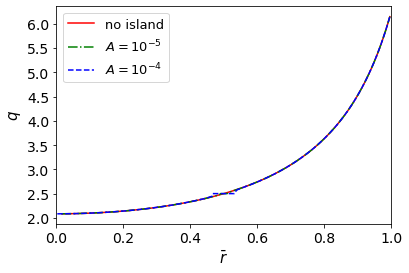

In [3]:
chilistpluss = -noA - np.linspace(0,1,1001) * 0.044 - 1e-9* noA
psibarpluss,Omega, qpluss = noisland.get_psibar_omega_q_passing(chilistpluss, sign=1)
chilistminuss = -noA - np.linspace(0,1,1001) * 0.00499 - 1e-9*noA
psibarminuss,Omega, qminuss = noisland.get_psibar_omega_q_passing(chilistminuss, sign=-1)

plt.plot(np.concatenate([np.flip(np.sqrt(psibarminuss/0.5)),np.sqrt(psibarpluss/0.5)]), np.concatenate([np.flip(qminuss), qpluss]), 'r-')


chilistplus = -smallA - np.linspace(0,1,1001) * 0.044 - 1e-9*smallA
psibarplus,Omega, qplus = smallisland.get_psibar_omega_q_passing(chilistplus, sign=1)
chilistminus = -smallA - np.linspace(0,1,1001) * 0.00498 - 1e-9*smallA
psibarminus,Omega, qminus = smallisland.get_psibar_omega_q_passing(chilistminus, sign=-1)

islandls = np.sqrt(np.max(psibarminus) / 0.5)
islandrs = np.sqrt(np.min(psibarplus) / 0.5)

print(islandrs - islandls)

plt.plot(np.concatenate([np.flip(np.sqrt(psibarminus/0.5)),[islandls, islandrs], np.sqrt(psibarplus/0.5)]), np.concatenate([np.flip(qminus),[q0,q0], qplus]), 'g-.')

chilistplus = -A - np.linspace(0,1,1001) * 0.044 - 1e-9*A
psibarplus,Omega, qplus = myisland.get_psibar_omega_q_passing(chilistplus, sign=1)
chilistminus = -A - np.linspace(0,1,1001) * 0.0049 - 1e-9*A
psibarminus,Omega, qminus = myisland.get_psibar_omega_q_passing(chilistminus, sign=-1)

islandl = np.sqrt(np.max(psibarminus) / 0.5)
islandr = np.sqrt(np.min(psibarplus) / 0.5)

print(islandr - islandl)

plt.plot(np.concatenate([np.flip(np.sqrt(psibarminus/0.5)),[islandl, islandr],np.sqrt(psibarplus/0.5)]),  np.concatenate([np.flip(qminus),[q0,q0], qplus]), 'b--')


# plt.plot([islandls, islandls], [2,6], 'k:')
# plt.plot([islandrs, islandrs], [2,6], 'k:')
# plt.plot([islandl, islandl], [2,6], 'k:')
# plt.plot([islandr, islandr], [2,6], 'k:')
plt.xlabel(r"$\bar{r}$", fontsize=15)
_ = plt.ylabel(r"$q$", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,1])
plt.legend(["no island",r"$A=10^{-5}$",r"$A=10^{-4}$"], fontsize=13)
plt.savefig('qprofile.eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


0.06379191430158687


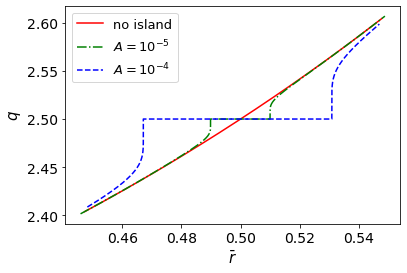

In [5]:
chilistpluss = -noA - 2*A * np.exp(np.linspace(-17,0,401))
psibarpluss,Omega, qpluss = noisland.get_psibar_omega_q_passing(chilistpluss, sign=1)
chilistminuss = -noA - 2*A * np.exp(np.linspace(-17,0,401))
psibarminuss,Omega, qminuss = noisland.get_psibar_omega_q_passing(chilistminuss, sign=-1)

plt.plot(np.concatenate([np.flip(np.sqrt(psibarminuss/0.5)),np.sqrt(psibarpluss/0.5)]), np.concatenate([np.flip(qminuss), qpluss]), 'r-')

chilistpluss = -smallA - 2*A * np.exp(np.linspace(-17,0,401))
psibarpluss,Omega, qpluss = smallisland.get_psibar_omega_q_passing(chilistpluss, sign=1)
chilistminuss = -smallA - 2*A * np.exp(np.linspace(-17,0,401))
psibarminuss,Omega, qminuss = smallisland.get_psibar_omega_q_passing(chilistminuss, sign=-1)

islandls = np.sqrt(np.max(psibarminuss) / 0.5)
islandrs = np.sqrt(np.min(psibarpluss) / 0.5)

plt.plot(np.concatenate([np.flip(np.sqrt(psibarminuss/0.5)),[islandls, islandrs],np.sqrt(psibarpluss/0.5)]), np.concatenate([np.flip(qminuss),[q0,q0], qpluss]), 'g-.')



chilistplus = -A -  A * np.exp(np.linspace(-17,0,401))
psibarplus,Omega, qplus = myisland.get_psibar_omega_q_passing(chilistplus, sign=1)
chilistminus = -A - A * np.exp(np.linspace(-17,0,401))
psibarminus,Omega, qminus = myisland.get_psibar_omega_q_passing(chilistminus, sign=-1)

islandl = np.sqrt(np.max(psibarminus) / 0.5)
islandr = np.sqrt(np.min(psibarplus) / 0.5)

print(islandr - islandl)

plt.plot(np.concatenate([np.flip(np.sqrt(psibarminus/0.5)), [islandl, islandr], np.sqrt(psibarplus/0.5)]), np.concatenate([np.flip(qminus), [q0, q0], qplus]), 'b--')


# plt.plot([islandl, islandl], [2.4,2.6], 'k-.')
# plt.plot([islandr, islandr], [2.4,2.6], 'k-.')
plt.xlabel(r"$\bar{r}$", fontsize=15)
_ = plt.ylabel(r"$q$", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(["no island",r"$A=10^{-5}$",r"$A=10^{-4}$"], fontsize=13)
plt.savefig('qprofile_zoom.eps', bbox_inches='tight')

#### $\Omega$ inside the island w.r.t. the centre of the island

#### 2.2.2 Continuum
The global eigenmode equation is given by
$$
\omega^2 \nabla \cdot \left( \frac{\mu_0 \rho}{B^2} \nabla_\perp \Phi \right) 
- B \nabla_\parallel \frac{1}{B^2} \nabla \cdot \left( B^2 \nabla_\perp \frac{\nabla_\parallel \Phi}{B} \right)
=0.
$$
Assuming the mode structure is singular across flux surfaces, one extracts the terms that have double radial derivatives and obtain the equation for the continuum as a function of flux surfaces.

Find $\omega^2$ such that the solution of the electric static potential on a flux surface satisfies the periodic boundary condition in both angles.
$$
\omega^2 \rho \frac{|\nabla \bar{\psi}|^2}{B^2} \Phi + \mathbf{B} \cdot \nabla \left( \frac{|\nabla \bar{\psi}|^2}{B^2} \mathbf{B} \cdot \nabla  \Phi \right) = 0.
$$

One can write $\Phi$ into the sum of a number of Fourier modes.
Outside the island,
$$
\Phi = \sum_{m=0}^{M} \sum_{n=0}^{N} \Phi_{m,n} e^{i (m M_{fp} + m_{start}) \bar{\theta} + i (n N_{fp} + n_{start}) \zeta}.
$$
Inside the island,
$$
\Phi = \sum_{m=0}^{M} \sum_{n=0}^{N} \Phi_{m,n} e^{i (m M_{fp} + m_{start}) \bar{\alpha} + i (n N_{fp} + n_{start}) \zeta / m_0}.
$$

#### Computation of continuum outside the island

1. $ A = 0$

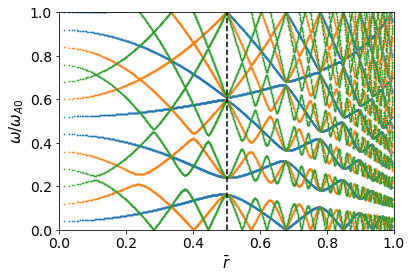

In [4]:
nlist = np.array([-1, -3, -5])
for i in range(nlist.size):
    n = nlist[i]
    mycont = Continuum(noisland, mstart=0, mcount=33, nstart=n, ncount=1,  mfp=1, nfp=1)

    chilistplus = -noA - np.linspace(0,1,801)[1:]**2 * 0.044 #- 1e-9* noA
    chilistminus = -noA - np.linspace(0,1,401)[1:]**2 * 0.00499# - 1e-9*noA
    #chilistplus = -noA - 2*A * np.exp(np.linspace(-12,0,401))
    #chilistminus = -noA - 2*A * np.exp(np.linspace(-12,0,401))
    psibarplus,Omega, qplus = noisland.get_psibar_omega_q_passing(chilistplus, sign=1)
    psibarminus,Omega, qminus = noisland.get_psibar_omega_q_passing(chilistminus, sign=-1)
    psibar, omega = mycont.compute_continuum(chilistplus, passing=True, sign=1)
    psibar2, omega2 = mycont.compute_continuum(chilistminus, passing=True, sign=-1)

    omega *= 3**2
    omega2 *= 3**2

    rp = np.sqrt(2 * psibar[:,None])
    rm = np.sqrt(2 * psibar2[:,None])
    r = np.concatenate([rm, rp])
    omega_combine = np.concatenate([omega2, omega])
    plt.scatter(np.broadcast_to(r, omega_combine.shape), np.sqrt(np.abs(omega_combine)), s=0.5)

#plt.legend([r"$n=-1$", r"$n=-3$", r"$n=-5$"], fontsize=13)

xpoints = np.array([np.min(rm), np.max(rp)])
plt.plot([np.min(rp),np.min(rp)], [0,1], 'k--')
plt.ylim([0.0,1])
plt.xlim([0,1])
plt.xlabel(r"$\bar{r}$", fontsize=15)
plt.ylabel(r"$\omega / \omega_{A0}$", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.plot(rm, abs(1/2/ qminus), 'k--')
#plt.plot(rp, abs(1/2/ qplus), 'k--')

plt.savefig('continuum_full.png', bbox_inches='tight')

-1
-3
-5


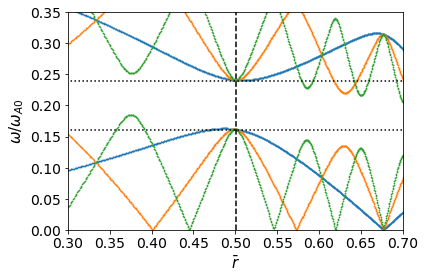

In [ ]:
nlist = np.array([-1, -3, -5])
for i in range(nlist.size):
    n = nlist[i]
    print(n)
    mycont = Continuum(noisland, mstart=1, mcount=33, nstart=n, ncount=1,  mfp=1, nfp=1)

    chilistplus = -noA - np.linspace(0,1,401)[1:-1]**2 * 0.005
    chilistminus = -noA - np.linspace(0,1,401)[1:-1]**2 * 0.005
    #chilistplus = -noA - 2*A * np.exp(np.linspace(-12,0,401))
    #chilistminus = -noA - 2*A * np.exp(np.linspace(-12,0,401))
    psibarplus,Omega, qplus = noisland.get_psibar_omega_q_passing(chilistplus, sign=1)
    psibarminus,Omega, qminus = noisland.get_psibar_omega_q_passing(chilistminus, sign=-1)
    psibar, omega = mycont.compute_continuum(chilistplus, passing=True, sign=1)
    psibar2, omega2 = mycont.compute_continuum(chilistminus, passing=True, sign=-1)

    omega *= 3**2
    omega2 *= 3**2

    rp = np.sqrt(2 * psibar[:,None])
    rm = np.sqrt(2 * psibar2[:,None])
    r = np.concatenate([rm, rp])
    omega_combine = np.concatenate([omega2, omega])
    plt.scatter(np.broadcast_to(r, omega_combine.shape), np.sqrt(np.abs(omega_combine)), s=0.5)

#plt.legend([r"$n=-1$", r"$n=-3$", r"$n=-5$"], fontsize=13)

xpoints = np.array([np.min(rm), np.max(rp)])
plt.plot([np.min(rp),np.min(rp)], [0,1], 'k--')
down = [0.16, 0.16]
up = [0.24,0.24]
plt.plot(xpoints, up, 'k:')
plt.plot(xpoints, down, 'k:')
plt.ylim([0.0,0.35])
plt.xlim([0.3, 0.7])
plt.xlabel(r"$\bar{r}$", fontsize=15)
plt.ylabel(r"$\omega / \omega_{A0}$", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.plot(rm, abs(1/2/ qminus), 'k--')
#plt.plot(rp, abs(1/2/ qplus), 'k--')

plt.savefig('continuum_zoom.png', bbox_inches='tight')

2. $A=1e-5$

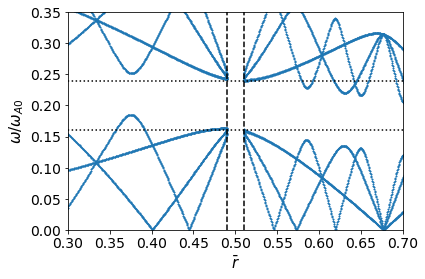

In [ ]:
mycont = Continuum(smallisland, mstart=-20, mcount=41, nstart=-5, ncount=6,  mfp=1, nfp=2)

chilistplus = -smallA - np.linspace(0,1,401)[1:-1]**2 * 0.005
chilistminus = -smallA - np.linspace(0,1,401)[1:-1]**2 * 0.003
#chilistplus = -noA - 2*A * np.exp(np.linspace(-12,0,401))
#chilistminus = -noA - 2*A * np.exp(np.linspace(-12,0,401))
psibarplus,Omega, qplus = smallisland.get_psibar_omega_q_passing(chilistplus, sign=1)
psibarminus,Omega, qminus = smallisland.get_psibar_omega_q_passing(chilistminus, sign=-1)
psibar, omega = mycont.compute_continuum(chilistplus, passing=True, sign=1)
psibar2, omega2 = mycont.compute_continuum(chilistminus, passing=True, sign=-1)

omega *= 3**2
omega2 *= 3**2

rp = np.sqrt(2 * psibar[:,None])
rm = np.sqrt(2 * psibar2[:,None])
r = np.concatenate([rm, rp])
omega_combine = np.concatenate([omega2, omega])
plt.scatter(np.broadcast_to(r, omega_combine.shape), np.sqrt(np.abs(omega_combine)), s=0.5)

#plt.legend([r"$n=-1$", r"$n=-3$", r"$n=-5$"], fontsize=13)

xpoints = np.array([np.min(rm), np.max(rp)])
down = [0.16, 0.16]
up = [0.24,0.24]
plt.plot(xpoints, up, 'k:')
plt.plot(xpoints, down, 'k:')
plt.plot([np.min(rp),np.min(rp)], [0,1], 'k--')
plt.plot([np.max(rm),np.max(rm)], [0,1], 'k--')
plt.ylim([0.0,0.35])
plt.xlim([0.3, 0.7])
plt.xlabel(r"$\bar{r}$", fontsize=15)
plt.ylabel(r"$\omega / \omega_{A0}$", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.plot(rm, abs(1/2/ qminus), 'k--')
#plt.plot(rp, abs(1/2/ qplus), 'k--')

plt.savefig('continuum_zoom_A-5.png', bbox_inches='tight')

3. $A=1e-4$

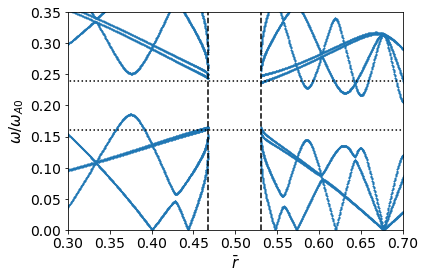

In [ ]:
mycont = Continuum(myisland, mstart=-20, mcount=41, nstart=-5, ncount=6,  mfp=1, nfp=2)

chilistplus = -A - np.linspace(0,1,501)[1:-1]**2 * 0.005
chilistminus = -A - np.linspace(0,1,501)[1:-1]**2 * 0.003
#chilistplus = -noA - 2*A * np.exp(np.linspace(-12,0,401))
#chilistminus = -noA - 2*A * np.exp(np.linspace(-12,0,401))
psibarplus,Omega, qplus = myisland.get_psibar_omega_q_passing(chilistplus, sign=1)
psibarminus,Omega, qminus = myisland.get_psibar_omega_q_passing(chilistminus, sign=-1)
psibar, omega = mycont.compute_continuum(chilistplus, passing=True, sign=1)
psibar2, omega2 = mycont.compute_continuum(chilistminus, passing=True, sign=-1)

omega *= 3**2
omega2 *= 3**2

rp = np.sqrt(2 * psibar[:,None])
rm = np.sqrt(2 * psibar2[:,None])
r = np.concatenate([rm, rp])
omega_combine = np.concatenate([omega2, omega])
plt.scatter(np.broadcast_to(r, omega_combine.shape), np.sqrt(np.abs(omega_combine)), s=0.5)

#plt.legend([r"$n=-1$", r"$n=-3$", r"$n=-5$"], fontsize=13)

xpoints = np.array([np.min(rm), np.max(rp)])
down = [0.16, 0.16]
up = [0.24,0.24]
plt.plot(xpoints, up, 'k:')
plt.plot(xpoints, down, 'k:')
plt.plot([np.min(rp),np.min(rp)], [0,1], 'k--')
plt.plot([np.max(rm),np.max(rm)], [0,1], 'k--')
plt.ylim([0.0,0.35])
plt.xlim([0.3, 0.7])
plt.xlabel(r"$\bar{r}$", fontsize=15)
plt.ylabel(r"$\omega / \omega_{A0}$", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.plot(rm, abs(1/2/ qminus), 'k--')
#plt.plot(rp, abs(1/2/ qplus), 'k--')

plt.savefig('continuum_zoom_A-4.png', bbox_inches='tight')

#### Remarks
- TAE gap mostly unchanged.
- More small gaps form due to toroidal mode coupling.

#### Continuum inside the island

In [5]:
mycont = Continuum(myisland, -50, 101, -11, 12,  mfp=1, nfp=2)
#mycont = Continuum(myisland, -8, 9, -1, 2,  mfp=2, nfp=2)
geo = ToroidalGeometry(a=1, R0=3, B0=1)
A = 0.0001
myisland = Island(geo, m0=m0, n0=n0, psi0=psi0, qprime=qprime, A=A)

In [6]:
chilist3 = 1 - 0.01 * np.exp(-np.linspace(0,12,11))
chilist1 = np.linspace(0, np.sqrt(chilist3[0]), 190, endpoint=False)**2 + 1e-5
chilist = A - np.concatenate([chilist1, chilist3]) * 2 * A
psibar, omega = mycont.compute_continuum(chilist, passing=False, sign=1)
omega *= 3**2
_,Omegat, qt = myisland.get_psibar_omega_q_trapped(chilist)

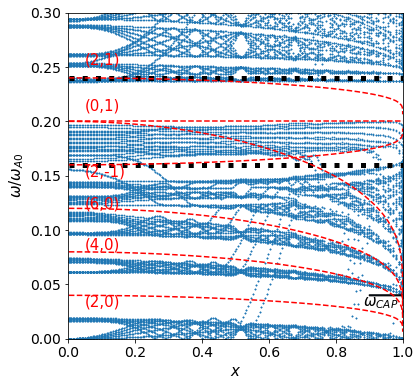

In [10]:
plt.rcParams['figure.figsize'] = [6,6]
w = 4 * np.sqrt(A * q0**2 / qprime)
psi_isl = 2* w / (np.pi * m0)

psibar,Omegat, qt = myisland.get_psibar_omega_q_trapped(chilist)
psibarm = psi_isl
x = np.sqrt(psibar[:,None]/psibarm)
plt.scatter(np.broadcast_to(x, omega.shape), np.sqrt(np.abs(omega)), s=0.5)
xpoints = np.sqrt(np.array([np.min(psibar), np.max(psibar)]) /psibarm)
down = [0.16, 0.16]
up = [0.24,0.24]
plt.plot(xpoints, up, 'k:', linewidth=5)
plt.plot(xpoints, down, 'k:', linewidth=5)
#plt.plot(psibar, np.abs( 0* Omegat + 1/5), 'r')

mlist = [2, 4, 6, 10, 2, 0, 2]
nlist = [0, 0, 0, 0, 1, 1, -1]

for i in range(len(mlist)):

    dm = mlist[i]
    dn = nlist[i]
    gap = np.abs(dn/q0 - dm * Omegat) / 2

    plt.plot(x,gap,'r--')

plt.text(0.05, 0.21, '(0,1)', c='r', fontsize=15)
plt.text(0.05, 0.252, '(2,1)',c='r', fontsize=15)
plt.text(0.05, 0.149, '(2,-1)',c='r', fontsize=15)
plt.text(0.05, 0.082, '(4,0)',c='r', fontsize=15)
plt.text(0.05, 0.03, '(2,0)',c='r', fontsize=15)
plt.text(0.05, 0.12, '(6,0)', c='r', fontsize=15)

plt.text(0.88, 0.03, r"$\omega_{CAP}$", c='k', fontsize=15)
plt.arrow(0.9,0.04, 0.15,0.0)

plt.xlim([0,1])
plt.ylim([0,0.3])
plt.xlabel(r"$x$", fontsize=15)
plt.ylabel(r"$\omega / \omega_{A0}$", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



plt.savefig('continuum_inside_A-4.png',dpi=300, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


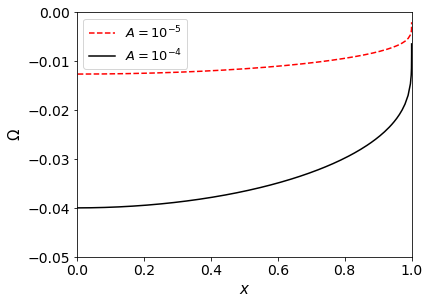

In [ ]:
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.plot(x,Omegat / np.sqrt(10), 'r--')
plt.plot(x,Omegat,'k-')
plt.xlim([0,1])
plt.ylim([-0.05, 0])
plt.xlabel(r"$x$", fontsize=15)
plt.ylabel(r"$\Omega$", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend([r"$A=10^{-5}$",r"$A=10^{-4}$"], fontsize=13)
plt.savefig('Omega.eps', bbox_inches='tight')

In [17]:
mycontout = Continuum(myisland, mstart=-40, mcount=81, nstart=-11, ncount=12,  mfp=1, nfp=2)

chilistplus = -A - np.linspace(0,1,201)[1:-1]**2 * 0.005
chilistminus = -A - np.linspace(0,1,201)[1:-1]**2 * 0.003

psibarplusout,Omega, qplusout = myisland.get_psibar_omega_q_passing(chilistplus, sign=1)
psibarminusout,Omega, qminusout = myisland.get_psibar_omega_q_passing(chilistminus, sign=-1)
psibarout, omegaout = mycontout.compute_continuum(chilistplus, passing=True, sign=1)
psibarout2, omega2out = mycontout.compute_continuum(chilistminus, passing=True, sign=-1)

omegaout *= 3**2
omega2out *= 3**2

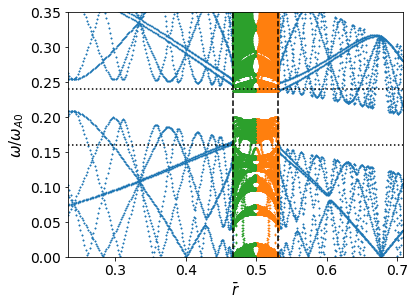

In [129]:
plt.rcParams['figure.figsize'] = [6,4.5]

rp = np.sqrt(2 * psibarout[:,None])
rm = np.sqrt(2 * psibarout2[:,None])
r = np.concatenate([rm, rp])
omega_combineout = np.concatenate([omega2out, omegaout])
plt.scatter(np.broadcast_to(r, omega_combineout.shape), np.sqrt(np.abs(omega_combineout)), s=0.5)

#plt.legend([r"$n=-1$", r"$n=-3$", r"$n=-5$"], fontsize=13)

xpoints = np.array([np.min(rm), np.max(rp)])
down = [0.16, 0.16]
up = [0.24,0.24]
plt.plot(xpoints, up, 'k:')
plt.plot(xpoints, down, 'k:')
plt.plot([np.min(rp),np.min(rp)], [0,1], 'k--')
plt.plot([np.max(rm),np.max(rm)], [0,1], 'k--')
plt.ylim([0.0,0.35])
plt.xlim(xpoints)
plt.xlabel(r"$\bar{r}$", fontsize=15)
plt.ylabel(r"$\omega / \omega_{A0}$", fontsize=15)

rleft = np.max(rm)
rright = np.min(rp)
rmid = 0.5 * (rleft + rright)
dr = (rright - rleft)

x = np.sqrt(psibar[:,None]/psibarm)
plt.scatter(np.broadcast_to(x * 0.5 * dr + rmid, omega.shape), np.sqrt(np.abs(omega)), s=0.3)
plt.scatter(np.broadcast_to(-x * 0.5 * dr + rmid, omega.shape), np.sqrt(np.abs(omega)), s=0.3)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.plot(rm, abs(1/2/ qminus), 'k--')
#plt.plot(rp, abs(1/2/ qplus), 'k--')

plt.savefig('continuum_combine_A-4.png',dpi=300,bbox_inches='tight')

In [ ]:
xpoints = np.array([np.min(rm), np.max(rp)])
down = [0.16, 0.16]
up = [0.24,0.24]
plt.plot(xpoints, up, 'k:')
plt.plot(xpoints, down, 'k:')
plt.plot([np.min(rp),np.min(rp)], [0,1], 'k--')
plt.plot([np.max(rm),np.max(rm)], [0,1], 'k--')
plt.ylim([0.0,0.35])
plt.xlim([0., 1])
plt.xlabel(r"$\bar{r}$", fontsize=15)
plt.ylabel(r"$\omega / \omega_{A0}$", fontsize=15)



#plt.plot(rm, abs(1/2/ qminus), 'k--')
#plt.plot(rp, abs(1/2/ qplus), 'k--')

#plt.savefig('continuum_combine_A-4.png', bbox_inches='tight')

#### Understanding the continuum gaps for a stellarator

In tokamaks, only poloidal coupling, TAE $\Delta m = 1$, EAE $\Delta m=2$, NAE $\Delta m =3$ ...

Middle of the gap frequency: $\omega / \omega_{A0} = \Delta m / (2q)$.

In stellarators, there are both poloidal coupling and toroidal coupling. 

Reference: Y. I. Kolesnichenko, V. V. Lutsenko, H. Wobig, Y. V. Yakovenko, and O. P. Fesenyuk, Alfvén Continuum and High-Frequency Eigenmodes in Optimized Stellarators, Phys. Plasmas 8, 491 (2001).

There will be new gaps 
- Mirror Alfven Eigenmode gap (MAE) $\Delta n = 1$.
- Helical Alfven Eigenmode gap (HAE) with non-zero $\Delta m$ and $\Delta n$.

Middle of the gap frequency: $\omega / \omega_{A0} = |\Delta n N_{fp} - \Delta m / q|/2$.

<img src="images/YK1.png" width="400"/>
<img src="images/YK2.png" width="400"/>

\omega/\omega_{A0} = 0.194968849073496
\omega/\omega_{A0} = 0.23752347387001602


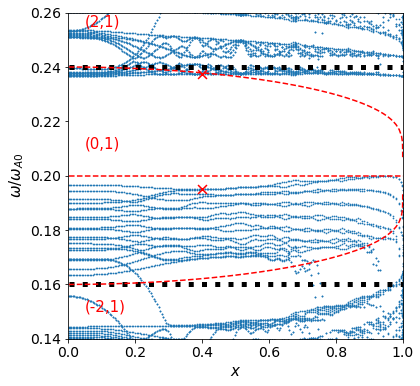

In [57]:
plt.rcParams['figure.figsize'] = [6,6]
plt.scatter(np.broadcast_to(np.sqrt(psibar[:,None]/psibarm), omega.shape), np.sqrt(np.abs(omega)), s=0.5)
xpoints = np.sqrt(np.array([np.min(psibar), np.max(psibar)]) /psibarm)
down = [0.16, 0.16]
up = [0.24,0.24]
plt.plot(xpoints, up, 'k:', linewidth=5)
plt.plot(xpoints, down, 'k:', linewidth=5)
plt.ylim([0.14,0.26])
plt.xlim([0,1])
plt.xlabel(r"$x$", fontsize=15)
plt.ylabel(r"$\omega / \omega_{A0}$", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
mlist = [2, 4, 6, 2, 0, -2]
nlist = [0, 0, 0, 1, 1,  1]

for i in range(len(mlist)):

    dm = mlist[i]
    dn = nlist[i]
    gap = np.abs(dn/q0 - dm * Omegat) / 2

    plt.plot(x,gap,'r--')

plt.text(0.05, 0.21, '(0,1)', c='r', fontsize=15)
plt.text(0.05, 0.255, '(2,1)',c='r', fontsize=15)
plt.text(0.05, 0.15, '(-2,1)',c='r', fontsize=15)

pos = 85
id = 100
r1 = np.sqrt(psibar[pos]/psibarm)
fqc = np.sqrt(omega[pos,id])
print(r"\omega/\omega_{A0} = "+ str(fqc))
plt.scatter(r1, fqc, c='r', marker='x', s=80)

id = 101
r1 = np.sqrt(psibar[pos]/psibarm)
fqc = np.sqrt(omega[pos,id])
print(r"\omega/\omega_{A0} = "+ str(fqc))
plt.scatter(r1, fqc, c='r', marker='x', s=80)

plt.savefig('continuum_inside_zoom_A-4.png', dpi=300, bbox_inches='tight')

In [36]:
omega[85,:]

array([9.30493133e-07, 9.30493178e-07, 1.36520897e-05, ...,
       2.40793541e+01, 2.47359527e+01, 2.47359527e+01])

#### Remarks
- TAE gap outside the island corresponds to MAE gap inside the island.
  
- If only $\Delta n = 1$ coupling is considered, then the MAE gap width matches the TAE gap width outside (can prove analytically).

- The MAE gap is narrower than the TAE gap outside, with the lower tip shifting up. Implications to global mode?

Reasons could be:

- Interaction between differnet gaps as they try to expel each other (here $\text{HAE}_{2,1}$ and MAE), see Kolesnichenko.
  
- If the nonaxisymmetry of the configuration is large enough, the continuum spectrum become localised, point spectrum with analogy to global Alfven gap modes, see Salat 2001.

### Gap width computed in the linear picture

In [ ]:
zeta = np.linspace(0, 10 * np.pi, 256, endpoint=False)
alphabar = np.linspace(0, 2*np.pi, 128, endpoint=False)

Atest = 0.0001
J, gradchi2, B2 = myisland.get_J_gradchi2_B2(0.99999*Atest, alphabar, zeta, False)

Bfft = np.fft.fft2(np.sqrt(B2.T)) / B2.size
gradchi2fft = np.fft.fft2(gradchi2.T) / B2.size
combI = J.T * gradchi2.T / B2.T
combfft = np.fft.fft2(combI) / B2.size

In [ ]:
delta = np.sqrt(A**2 *m0 ** 2 / (A * qprime / q0**2) /r0**4)
eps = 0.5 / 3
deltaprime = eps/4
print(delta)
print(eps)

0.25
0.16666666666666666


### MAE Gap width from estimation
$$
    \Delta \omega_{\text{MAE}} \approx 2 \left[  \epsilon_0 +  \Delta' - \frac{\delta^2}{1 + \delta^2} \left( \epsilon_0 + 2 \Delta' \right) \right] \omega_{\text{MAE}}.
$$

In [ ]:
delta = np.sqrt(A**2 *m0 ** 2 / (A * qprime / q0**2) /r0**4)
eps = 0.5 / 3
deltaprime = eps/4
wMAEisland = 2 * (eps + deltaprime - delta**2/(1+delta**2)*(eps + 2 * deltaprime)) * 1/2/q0
delta = np.sqrt(smallA**2 *m0 ** 2 / (smallA * qprime / q0**2) /r0**4)
eps = 0.5 / 3
deltaprime = eps/4
wMAEislandsmall = 2 * (eps + deltaprime - delta**2/(1+delta**2)*(eps + 2 * deltaprime)) * 1/2/q0
wMAE = 2 * (eps + deltaprime) * 1/2/q0
print(wMAEisland)
print(wMAEislandsmall)
print(wMAE)

0.07745098039215685
0.08271221532091097
0.08333333333333333


In [ ]:
1/q0/(2*0.04) / 8 * 0.11031105375332835**2 * 1 / 2 / q0

0.001521066072521212

### MAE Gap width from measurement

In [ ]:
pos = 0
id = 100
fqc = np.sqrt(omega[pos,id])
pos = 0
id = 101
fqc2 = np.sqrt(omega[pos,id])
print(psibar[pos])
print(r"\Delta\omega/\omega_{A0} = "+ str(fqc2 - fqc))

5.000006250123243e-08
\Delta\omega/\omega_{A0} = 0.04003430164913499


In [ ]:
print((1-delta**2)/(1+delta**2))
print(2 * (deltaprime - delta**2 * (eps + deltaprime)) / (1+delta**2))
print((deltaprime + delta**2 * (eps + deltaprime) + 1 * delta * (eps + deltaprime * 2))/(1+delta**2))
print((deltaprime + delta**2 * (eps + deltaprime) - 1 * delta * (eps + deltaprime * 2))/(1+delta**2))

0.8823529411764706
0.053921568627450976
0.11029411764705882
-0.007352941176470588


In [ ]:
print(Bfft[0,2] / Bfft[0,0] + Bfft[0,-2] / Bfft[0,0])
print(Bfft[2,0] / Bfft[0,0]+Bfft[-2,0] / Bfft[0,0])
print(Bfft[2,2] / Bfft[0,0])
print(Bfft[2,-2] / Bfft[0,0])

print('-----')

print(gradchi2fft[0,2] / gradchi2fft[0,0] + gradchi2fft[0,-2] / gradchi2fft[0,0])
print(gradchi2fft[2,0] / gradchi2fft[0,0]+gradchi2fft[-2,0] / gradchi2fft[0,0])
print(gradchi2fft[2,2] / gradchi2fft[0,0]+gradchi2fft[-2,-2] / gradchi2fft[0,0])
print(gradchi2fft[2,-2] / gradchi2fft[0,0] + gradchi2fft[-2,2] / gradchi2fft[0,0])

(3.1457599786999026e-10+3.468544170466019e-26j)
(-0.17197397050759053-2.116091444313832e-18j)
(-1.3020078396092723e-08-1.9802701760018816e-19j)
(-3.4054686801040756e-09-8.304951361147218e-19j)
-----
(0.8818320897035695-1.5772856486972964e-19j)
(0.05381156055800194-8.071991260976395e-19j)
(0.11031105375332835-9.278150874742183e-21j)
(-0.007303335450597716-1.2432722172078597e-18j)


##### What is the mode structure (what m and n)?

Actually the spectrum is quite board due to strong toroidal and poloidal coupling and you can't tell which m and n

In [126]:
def plot_mode(id, pos):
    mycont = Continuum(myisland, -50, 101, -11, 12,  mfp=1, nfp=2)
    psibar_test, omega_test, vlist = mycont.compute_continuum(chilist[pos:pos+1], passing=False, eigenvector=True)
    omega_test = omega_test * 3**2
    fqc = np.sqrt(omega_test[0,id])
    psibar_test,Omegat_test, qt_test = myisland.get_psibar_omega_q_trapped(chilist[pos:pos+1])
    print(r"\omega/\omega_{A0} = "+ str(fqc))

    # plt.figure()
    # plt.scatter(np.broadcast_to(np.sqrt(psibar[:,None]/psibarm), omega.shape), np.sqrt(np.abs(omega)), s=0.5)
    # xpoints = np.sqrt(np.array([np.min(psibar), np.max(psibar)]) /psibarm)
    # up = [0.165, 0.165]
    # down = [0.235,0.235]
    # plt.plot(xpoints, up, 'k')
    # plt.plot(xpoints, down, 'k')
    # plt.scatter(r1, fqc, c='r')
    # plt.ylim([0.15,0.25])
    # plt.xlabel(r"$\sqrt{\bar{\psi}/\bar{\psi}_{edge}}$")
    # plt.ylabel(r"$\omega / \omega_{A0}$")

    # plt.figure()
    v = np.reshape(vlist[-1][:,id], [mycont.mcount, mycont.ncount])
    mm, nn = v.shape
    # for i in range(nn):
    #     plt.plot(mycont.mlist, np.real(v[:, i]))
    # plt.xlabel('m')
    # plt.legend(["n=" + str(mycont.nlist[i]) for i in range(nn)])

    plt.figure()
    zeta = np.linspace(0, 10 * np.pi, 256*2, endpoint=False)
    alphabar = np.linspace(0, 2*np.pi, 128*2, endpoint=False)
    phi = np.sum(v[:,:,None, None] * np.exp(complex(0,1) * (mycont.mlist[:,None,None,None] * alphabar[None,None,:,None] + mycont.nlist[None,:,None,None] * zeta[None,None,None,:] / 5)), (0,1))
    phi = phi / np.max(np.abs(phi))
    plt.contourf(alphabar/(2*np.pi), zeta/(2*np.pi), np.abs(phi).T)
    plt.clim(0,1)
    plt.xlim(0,1)
    plt.ylim(0,5)
    plt.xlabel(r"$\bar{\alpha}/(2\pi)$", fontsize=15)
    plt.ylabel(r"$\zeta/(2\pi)$", fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.colorbar()
    plt.title(r"$|\Phi|$ (A.U.)", fontsize=15)
    
    # plt.figure()
    # plt.plot(alphabar, np.real(phi[:,256//4]))
    # plt.xlabel(r"$\bar{\alpha}$")
    # plt.title(r"Amplitute at $\zeta = 5 \pi$")
    # plt.show()
    print(np.max(np.real(phi)))
    print(np.max(np.imag(phi)))
    print(np.max(np.abs(phi)))


    Bt = np.ones_like(np.real(phi.T)) * Omegat_test[0]
    Bz = np.ones_like(np.real(phi.T))

    plt.streamplot(alphabar/(2*np.pi), zeta/(2*np.pi), Bt, Bz, density=[0.5,0.5], color='r')

1. For a mode quite on the lower MAE tip

\omega/\omega_{A0} = 0.194968849073496
3.4381596497273945e-11
0.9999999999999998
0.9999999999999999


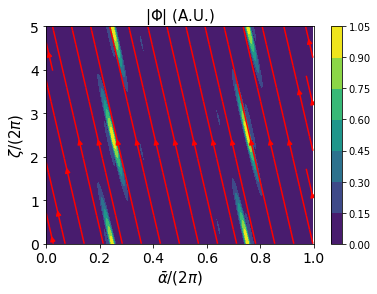

In [127]:
plt.rcParams['figure.figsize'] = [6,4]
plot_mode(100, 85)
plt.savefig('eigenmode_localised.png', dpi=300, bbox_inches='tight')

2. For a mode just on the upper MAE tip

\omega/\omega_{A0} = 0.23752347387001602
4.0352904387230064e-12
0.9999999999999999
1.0


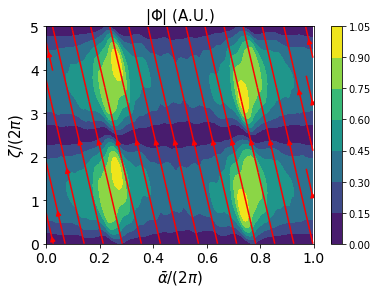

In [196]:
plt.rcParams['figure.figsize'] = [6,4]
plot_mode(101, 85)
plt.savefig('eigenmode_global.png', dpi=300, bbox_inches='tight')

#### Remarks

- The lower tip mode is quite localised in angle so it is indeed the Salat type.
- The upper tip mode is not localised.
- What lead to up-shift???

#### Parameter scan : island width vs lower tip frequency

In [ ]:
Alist = np.linspace(0.0001, 0.01, 10) ** 2
fqclist = np.zeros_like(Alist)

for i in range(Alist.size):
    AA = Alist[i]
    myisland1 = Island(geo, m0=m0, n0=n0, psi0=psi0, qprime=qprime, A=AA)
    mycont1 = Continuum(myisland1, -45, 91, -9, 10, fft_multiplier=8,  mfp=1, nfp=2)
    chilist = np.atleast_1d(-AA + np.linspace(0, 2, 101)[-21] * AA)
    psibar, omega = mycont1.compute_continuum(chilist, passing=False, sign=1)
    omega *= 3**2
    _,Omegat, qt = myisland1.get_psibar_omega_q_trapped(chilist)
    
    fqclist[i] = np.sqrt(omega[0, 91]) - np.sqrt(omega[0, 90])


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


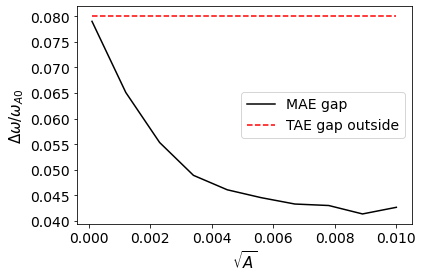

In [ ]:
plt.rcParams['figure.figsize'] = [6,4]
plt.plot(np.sqrt(Alist), fqclist, 'k-')
plt.plot(np.sqrt(Alist), np.ones_like(fqclist) * 0.08, 'r--')
plt.xlabel(r"$\sqrt{A}$", fontsize=15)
plt.ylabel(r"$\Delta \omega/\omega_{A0}$", fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['MAE gap', 'TAE gap outside'], fontsize=14)

plt.savefig('MAE_width.eps',bbox_inches='tight')

### Poincare plot of the configuration

In [3]:
import pyoculus as oculus
from pyoculus.problems import ToroidalBfield
from pyoculus.solvers import PoincarePlot

In [4]:
class LargeAspectRatioBfield(ToroidalBfield):
    def __init__(self, geometry, island):
        self.g = geometry
        self.i = island
        self.Nfp = 1
        super().__init__()
        

    def B(self, coords, *args):

        psi = coords[0]
        t = coords[1]
        z = coords[2]

        q = 1 / (1 / self.i.q0 - self.i.qprime / self.i.q0 ** 2 * (psi - self.i.psi0))
        JBs = self.i.A * self.i.m0 * np.sin(self.i.m0 * t - self.i.n0 * z)
        JBt = 1 / q
        JBz = 1

        return np.array([JBs, JBt, JBz])

    def convert_coords(self, coord1):
        psi = coord1[0]
        t = coord1[1]
        z = coord1[2]
        R0 = self.g.R0
        B0 = self.g.B0
        r = np.sqrt(2 * psi / B0)
        dpsidr = r * B0
        delta = r**2/R0 / 8 - self.g.a**2 / R0 / 8
        deltaprime = r / R0 / 4
        ddeltaprime = 1 / R0 / 4
        costheta = np.cos(t)
        sintheta = np.sin(t)
        eta = (r/R0 + deltaprime)/2
        
        R = R0 + r * costheta  - delta + r * eta * (np.cos(2*t) - 1)
        Z = r * sintheta + r * eta * np.sin(2 * t)
        RpZ = np.array([R, -z, Z])

        return RpZ

In [22]:
ps = LargeAspectRatioBfield(geo, myisland)

iparams = dict()
iparams['rtol'] = 1e-9

# set up the Poincare plot
pparams = dict()
pparams['Nfp'] = 1
pparams['sbegin'] = 0.1**2
pparams['send'] = 0.5
pparams['nPtrj'] = 40
pparams['nPpts'] = 500
pparams['theta'] = 0.0
pparams['zeta'] =0.0

pplot = PoincarePlot(ps,pparams,integrator_params=iparams)
pdata=pplot.compute()

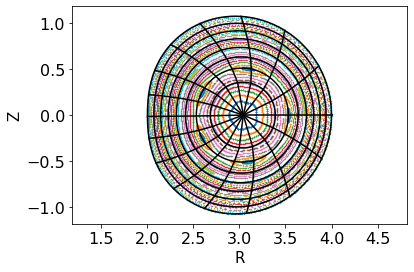

In [32]:
plt.rcParams['figure.figsize'] = [6,4]
pplot.plot('RZ', s=0.5)

ps = LargeAspectRatioBfield(geo, myisland)
zeta = 0
nt = 128
nr = 9
thetalist = np.linspace(0, 2 * np.pi, nt)
psilist = np.linspace(0,0.5, nr)

R = np.zeros([nr, nt])
Z = np.zeros([nr, nt])
for i in range(nr):
    for j in range(nt):
        RpZ = ps.convert_coords([psilist[i],thetalist[j],zeta])
        R[i,j] = RpZ[0]
        Z[i,j] = RpZ[2]

for i in range(nr):
    plt.plot(R[i,:], Z[i,:], '-',c='k') 

for j in range(0, nt, 8):
    plt.plot(R[:,j], Z[:,j], '-', c='k') 

plt.xlabel('R', fontsize=15)
plt.ylabel('Z', fontsize=15)
plt.savefig('geometry.png', dpi=300, bbox_inches='tight')

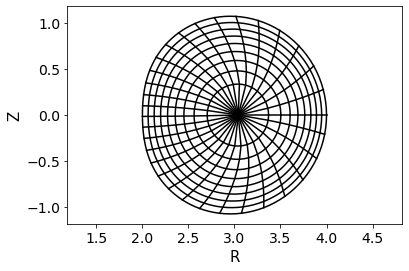

In [21]:
plt.rcParams['figure.figsize'] = [6,4]

ps = LargeAspectRatioBfield(geo, myisland)
zeta = 0
nt = 128
nr = 10
thetalist = np.linspace(0, 2 * np.pi, nt)
psilist = np.linspace(0,0.5, nr)

R = np.zeros([nr, nt])
Z = np.zeros([nr, nt])
for i in range(nr):
    for j in range(nt):
        RpZ = ps.convert_coords([psilist[i],thetalist[j],zeta])
        R[i,j] = RpZ[0]
        Z[i,j] = RpZ[2]

plt.figure()
for i in range(nr):
    plt.plot(R[i,:], Z[i,:], 'k-') 

for j in range(0, nt, 4):
    plt.plot(R[:,j], Z[:,j], 'k-') 

plt.xlabel('R', fontsize=15)
plt.ylabel('Z', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axis("equal")
plt.savefig('unperturbed.png', dpi=300, bbox_inches='tight')

In [9]:
print(Z[1,:])

[ 0.00000000e+00  2.41715432e-02  4.72225413e-02  6.80995509e-02
  8.58771443e-02  9.98072596e-02  1.09353107e-01  1.14205716e-01
  1.14283315e-01  1.09715738e-01  1.00817547e-01  8.80544778e-02
  7.20079310e-02  5.33416255e-02  3.27733288e-02  1.10529973e-02
 -1.10529973e-02 -3.27733288e-02 -5.33416255e-02 -7.20079310e-02
 -8.80544778e-02 -1.00817547e-01 -1.09715738e-01 -1.14283315e-01
 -1.14205716e-01 -1.09353107e-01 -9.98072596e-02 -8.58771443e-02
 -6.80995509e-02 -4.72225413e-02 -2.41715432e-02 -2.94381389e-17]
